In [340]:
import statsmodels.tsa.holtwinters as hw
import statsmodels.tsa.statespace.exponential_smoothing as hw_ss
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.optimize import curve_fit
import datetime as dt
import matplotlib.pyplot as plt

In [341]:
us_data = pd.read_csv("../covid-tracking-data/data/us_daily.csv", index_col="date", parse_dates=["date"])[::-1]

# Remove data before 2-28, where there were single digit case counts
start_date = pd.to_datetime("20200228")
#end_date = pd.to_datetime   ("20200420")
end_date = us_data.index[-1]
us_data = us_data[(us_data.index >= start_date) & (us_data.index <= end_date)]

In [342]:
us_data

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7de1cbe8b7b0a50a3afdd4b9c4d69ff78318681e,2020-02-28T21:00:00Z,4.0,NaN,9,9,9,2.0,0.0,0.0,7.0,7.0
2020-02-29,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243260e18d47e670dade08ee5a5195fcc8b5a9db,2020-02-29T21:00:00Z,5.0,NaN,18,18,18,1.0,0.0,0.0,9.0,9.0
2020-03-01,3,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca260a1247d2b0574d24373499373db27272de6e,2020-03-01T21:00:00Z,8.0,NaN,40,40,40,3.0,0.0,0.0,22.0,22.0
2020-03-02,3,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6513d03460ba39e3593914dcf26e9686a6102c3a,2020-03-02T21:00:00Z,11.0,NaN,53,53,53,3.0,0.0,0.0,13.0,13.0
2020-03-03,3,94,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86770db4d6896557717aeae87fff9e3b90548964,2020-03-03T21:00:00Z,14.0,NaN,100,100,100,3.0,0.0,6.0,41.0,47.0
2020-03-04,16,209,759.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469fa0e70ed7d25e9989fc688df5f75ebb22cb54,2020-03-04T21:00:00Z,16.0,NaN,1071,968,968,2.0,0.0,753.0,115.0,868.0
2020-03-05,25,277,970.0,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,768dda12019c1c607c700e84339f3bd87c900dbd,2020-03-05T21:00:00Z,20.0,NaN,1444,1247,1247,4.0,0.0,211.0,68.0,279.0
2020-03-06,37,395,1588.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16267a92330f7d42a4d88b8dc381bcb09b0170e6,2020-03-06T21:00:00Z,26.0,NaN,2441,1983,1983,6.0,0.0,618.0,118.0,736.0
2020-03-07,51,551,1839.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e92591fefd3041aea638f41d7849f63abeda92c0,2020-03-07T21:00:00Z,27.0,NaN,2992,2390,2390,1.0,0.0,251.0,156.0,407.0


In [343]:
# Compare different parameters for the model by calculating
# the SSE for different models.

#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

params = []
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    es = hw.ExponentialSmoothing(
        us_data['positive'][(us_data.index <= end_date)],
        trend=t,
        freq='D',
        damped=d,
    )
    fit = es.fit()
    params.append((fit.sse, fit, es, t, d))
    print("Trend: %s, Damped: %s, SSE: %f" % (t,d,fit.sse))
    
# Select the best model according to SSE
best = min(params)
best_fit = best[1]
best_model = best[2]
print('Selecting: Trend: %s, Damped: %s, SSE: %f ' % (best[3], best[4], best[0]))

Trend: mul, Damped: True, SSE: 503210350.834203
Trend: mul, Damped: False, SSE: 712309180.694174
Trend: add, Damped: True, SSE: 545393280.218387
Trend: add, Damped: False, SSE: 545391500.039573
Selecting: Trend: mul, Damped: True, SSE: 503210350.834203 


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


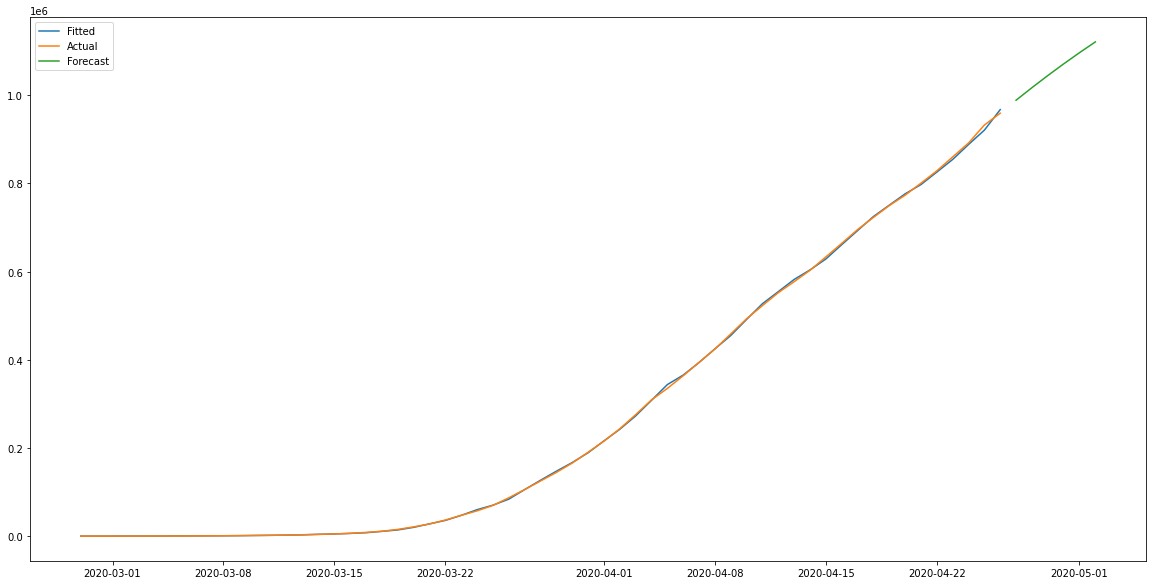

In [344]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(best_fit.fittedvalues, label="Fitted")
ax.plot(us_data['positive'], label="Actual")

ax.plot(best_fit.forecast(6), label="Forecast")
plt.legend()

#fit1.params_formatted

In [345]:
best_fit.forecast(6).index[-1]

Timestamp('2020-05-02 00:00:00', freq='D')

In [346]:
pd.to_datetime('2020-04-01') + pd.to_timedelta('1 day')

delta = us_data.index[-1] - us_data.index[0]

delta.days

58

In [347]:
# Search for the best model params by backtesting 7-day
# forecasts.

#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

results = []
# Search through different model params
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    pct_errors = list()
    # Backtest by fitting a model and producing a 6 day
    # forecast for every day in our history.
    for day_offset in range(1, delta.days-6):
        end_date = us_data.index[0] + pd.to_timedelta('%d day' % day_offset)
        es = hw.ExponentialSmoothing(
            us_data['positive'][(us_data.index <= end_date)],
            trend=t,
            freq='D',
            damped=d,
        )
        fit = es.fit()
        f = fit.forecast(7)
        # Get the actual number for the forecast day
        actual = us_data[us_data.index == f.index[-1]]['positive']
        # Calculate the percent error of the forecast
        pct_error = (f[-1]-actual[0])/actual[0]
        #print("%s %s Actual: %d Forecast: %d Error: %.2f" % (end_date.strftime('%Y/%m/%d'), f.index[-1].strftime('%Y/%m/%d'), actual[0], f[-1], pct_error * 100))
        pct_errors.append(pct_error)
    results.append(((t,d),pct_errors))
    print(t,d)
    print(np.percentile((pct_errors[-30:]), q = [5, 10, 50, 90, 95]))
    

/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

mul True
[-0.19058352 -0.1426644  -0.008189    0.30495297  0.50647204]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

mul False
[0.01739068 0.02209982 0.1858236  0.69221978 0.73449407]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add True
[-0.31950726 -0.28086197 -0.02494721  0.02629577  0.04585576]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add False
[-0.31934673 -0.28070071 -0.02486274  0.02640197  0.04601589]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

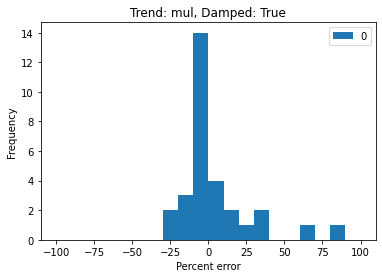

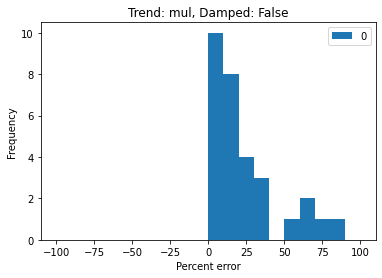

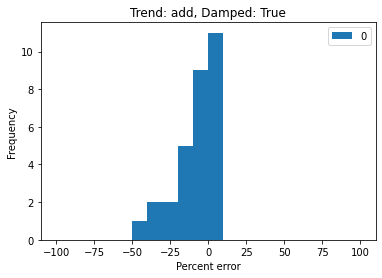

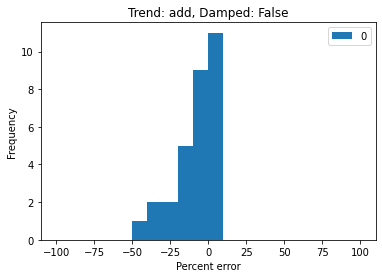

In [348]:
# Graph the histogram of percent errors over the backtested
# forecasts

for (p, errors) in results:
    errors_df = pd.DataFrame(errors)[-30:]
    ax = (errors_df * 100).plot(kind='hist', bins=range(-100,101,10), title='Trend: %s, Damped: %s' % (p[0],p[1]))
    ax.set_xlabel('Percent error')
    plt.savefig("errors-%s-%s.png" % (p[0],p[1]))
    #print (p, errors)

2020-04-27    9.884680e+05
2020-04-28    1.016906e+06
2020-04-29    1.044353e+06
2020-04-30    1.070798e+06
2020-05-01    1.096240e+06
2020-05-02    1.120679e+06
2020-05-03    1.144122e+06
Freq: D, dtype: float64


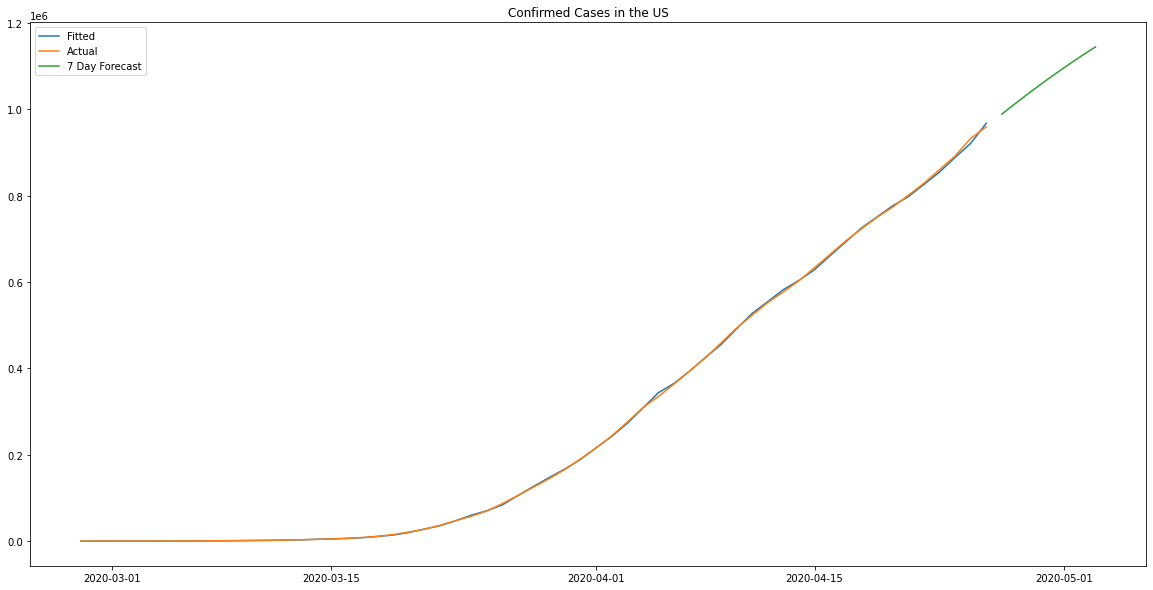

In [349]:
# 10 day forecast using multiplicative trend and dampening
es = hw.ExponentialSmoothing(
    us_data['positive'],
    trend='mul',
    freq='D',
    damped=True,
)
fit = es.fit(optimized=True)

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(fit.fittedvalues, label="Fitted")
ax.plot(us_data['positive'], label="Actual")

ax.plot(fit.forecast(7), label="7 Day Forecast")
plt.title("Confirmed Cases in the US")
plt.yscale('linear')
plt.legend()

plt.savefig("us_7_day.png")

print(fit.forecast(7))

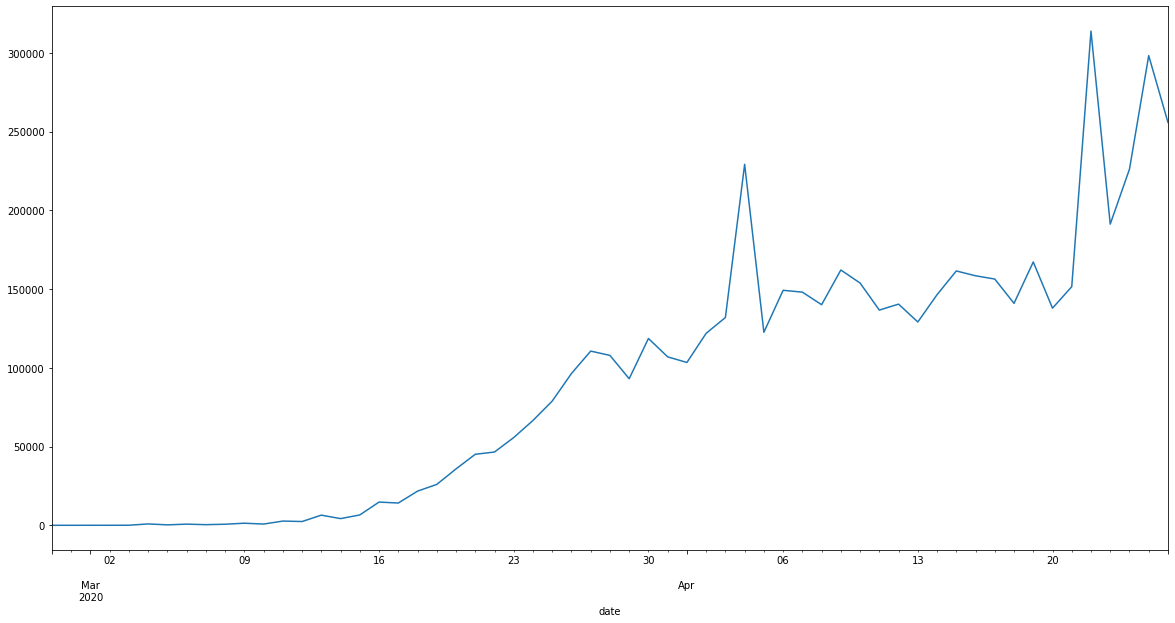

In [350]:
us_data['totalTestResultsIncrease'].plot(figsize=(20,10))

In [351]:
# Train 1 model per state, and create a forecast by
# summing the states.

state_data = pd.read_csv('../covid-tracking-data/data/states_daily_4pm_et.csv', index_col='date', parse_dates=['date'])[::-1]

In [363]:
# Remove AS because it has no cases. A multiplicative
# exponential smoothing model doesn't work with 0 values.
all_states = set(state_data.state.to_list()) - set(['AS'])

In [359]:
state_fits = {}
for state in all_states:
    print(state)
    single_state = state_data[(state_data['state'] == state) & (state_data['positive'] > 0)]
    es = hw.ExponentialSmoothing(
        single_state['positive'], #[(us_data.index <= end_date)],
        trend='mul',
        freq='D',
        damped=True,
    )
    fit = es.fit()
    f = fit.forecast(7)
    state_fits[state] = {'fit': fit, 'forecast': f}

IA
MP
DC
NM
DE
OK
ND
ID


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


WV
KY
NE
CA
WA
NV
MS
MD
MA
OR


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


WI
UT
NH
VA
OH
PA


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


MN
MT
PR
HI
CO
SD


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


NC
VT


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


NY
AR
TX
GU
LA
SC
GA
AL
NJ
KS


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


RI
FL


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


MI
AZ
AK
ME
VI
CT
IN
WY
IL
TN
MO


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [360]:
state_fits['CO']['forecast']+state_fits['WA']['forecast']

2020-04-27    26898.486035
2020-04-28    27583.061469
2020-04-29    28254.940494
2020-04-30    28913.120555
2020-05-01    29556.721689
2020-05-02    30184.984492
2020-05-03    30797.266766
Freq: D, dtype: float64

In [361]:
all = []
for k in state_fits:
    all.append(state_fits[k]['forecast'][pd.to_datetime('20200503')])

In [362]:
np.sum(all)

1138502.5351195864

In [ ]:
all